In [1]:
import torch
import numpy as np
from hysteresis.base import BaseHysteresis
from hysteresis.training import train_hysteresis
from hysteresis.visualization import plot_hysterion_density
import matplotlib.pyplot as plt

In [2]:
def get_data(fname):

    data = []
    with open(fname,'r') as f:
        f.readline()
        for line in f:
            temp = line.rstrip().split(' ')
            d = []
            for ele in temp:
                if ele != '':
                    d += [ele]
            data += [d]
    data = np.asfarray(data)
    return data

(187, 9)


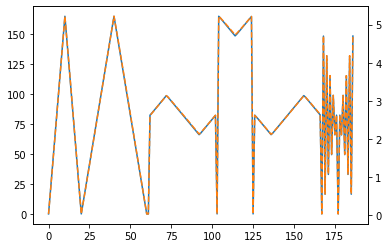

In [3]:
full_data = []
for ele in range(3,9):
    fname = f'data/strplt.ru{ele}'
    full_data += [get_data(fname)]
full_data = np.vstack(full_data)
print(full_data.shape)

# get real h, m
h = torch.tensor(full_data[:,1]).double()
m = torch.tensor(full_data[:,3]).double()

n_train = 103
h_train = h[:n_train]
m_train = m[:n_train]

fig, ax  = plt.subplots()
ax.plot(h)
axb = ax.twinx()
axb.plot(m,'--C1')

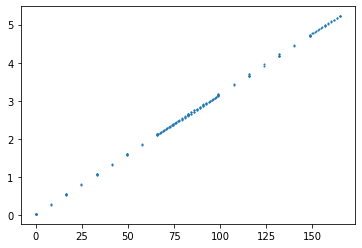

In [4]:
fig,ax = plt.subplots()
ax.plot(h, m,'o',ms=1)

0
7411
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


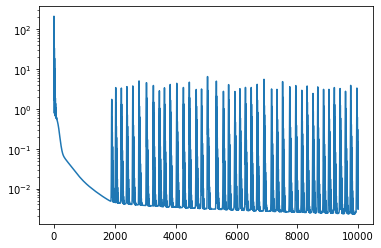

In [5]:
# fit using normal hysteresis model
H = BaseHysteresis(
    h_train,
    m_train,
    mesh_scale = 0.1,
    fixed_domain=torch.tensor((torch.min(h), torch.max(h)))
)
print(len(H.mesh_points))
# train on data
loss_trace = train_hysteresis(
    H,
    10000,
    lr=0.01,
    atol=1e-8,
)
fig, ax = plt.subplots()
ax.semilogy(loss_trace)

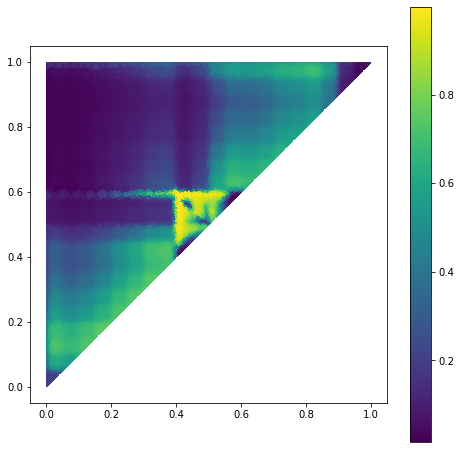

In [6]:
fig,ax,c = plot_hysterion_density(H)
ax.set_aspect('equal')
fig.set_size_inches(8,8)

In [7]:
for name, val in H.named_parameters():
    print(f'{name}:{val}')

raw_hysterion_density:Parameter containing:
tensor([-1.1342, -2.1761, -1.2888,  ..., -3.5108,  0.1781, -1.3818],
       requires_grad=True)
raw_offset:Parameter containing:
tensor([0.0103], requires_grad=True)
raw_scale:Parameter containing:
tensor([-5.3569], requires_grad=True)
raw_slope:Parameter containing:
tensor([-0.0213], requires_grad=True)
transformer._poly_fit.weights:Parameter containing:
tensor([0.0317])
transformer._poly_fit.bias:Parameter containing:
tensor([-0.0003])


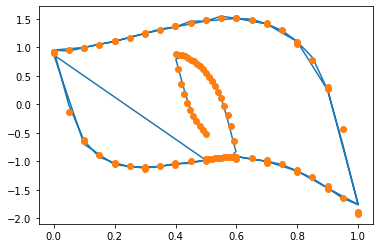

In [8]:
# plot regression
fig, ax = plt.subplots()
m_pred = H(h_train)
th, tm = H.transformer.transform(h_train, m_train)

ax.plot(th, m_pred.detach())
ax.plot(th, tm,'o')


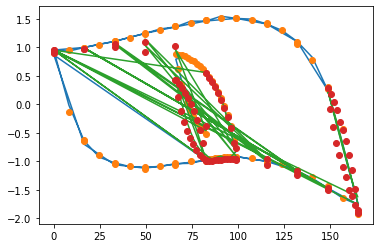

In [9]:
# plot prediction
fig2, ax2 = plt.subplots()
fig.set_size_inches(10,10)

H.regression()
m_regression = H(h)
th, tm = H.transformer.transform(h, m)

ax2.plot(h[:n_train], m_regression[:n_train].detach())
ax2.plot(h[:n_train], tm[:n_train],'o')

# plot future points
ax2.plot(h[n_train:], m_regression[n_train:].detach())
ax2.plot(h[n_train:], tm[n_train:],'o')


train RMS percentage error 1.4074915764782068
test RMS percentage error 4.255982205763468


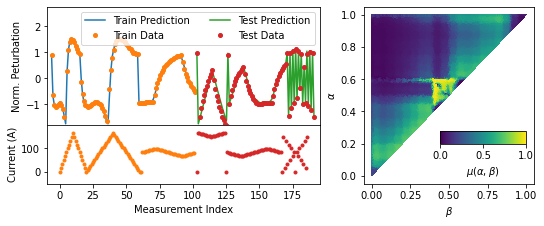

In [10]:
gridspec_kw = dict(height_ratios=[2,1], hspace=0.0,width_ratios=[2,1.25],right=0.97,
                   top=0.97,bottom=0.15,)
fig2 = plt.figure()
spec = fig2.add_gridspec(2,2, **gridspec_kw)

ax2 = fig2.add_subplot(spec[0,0])
ax3 = fig2.add_subplot(spec[1,0])
ax4 = fig2.add_subplot(spec[:,1])

fig2.set_size_inches(8,3)
ms=4
idx = torch.arange(len(tm))
ax2.plot(idx[:n_train], m_regression[:n_train].detach(), label='Train Prediction')
ax2.plot(idx[:n_train], tm[:n_train],'o',ms=ms, label='Train Data')

# plot future points
ax2.plot(idx[n_train:], m_regression[n_train:].detach(), label='Test Prediction')
ax2.plot(idx[n_train:], tm[n_train:],'o',ms=ms, label='Test Data')
ax2.set_ylabel('Norm. Peturbation')
ax2.set_ylim(-1.8, 2.75)
ax2.set_xlim(-3, 190)
ax2.legend(ncol=2)#loc=2)
frac_error = 100.0*(tm - m_regression) / (torch.max(tm)-torch.min(tm))
print(f'train RMS percentage error {torch.std(frac_error[:n_train])}')
print(f'test RMS percentage error {torch.std(frac_error[n_train-1:])}')

ax3.plot(idx[n_train:], h[n_train:],'.C3')
ax3.plot(idx[:n_train-1], h[:n_train-1],'.C1')
ax3.set_ylabel('Current (A)')
ax3.set_ylim(-50, 199)
ax3.set_xlabel('Measurement Index')

_, _, c = plot_hysterion_density(H,ax=ax4)
c.set_clim(0,1)
# embed colorbar inside plot
box = ax4.get_position()
width = box.width
height = box.width
rect = [0.45,0.225,0.5,0.2]
inax_position  = ax4.transAxes.transform(rect[0:2])
transFigure = fig2.transFigure.inverted()
infig_position = transFigure.transform(inax_position)
x = infig_position[0]
y = infig_position[1]
width *= rect[2]
height *= rect[3]
new_rect= [x,y,width,height]
cax = fig2.add_axes(new_rect)

cax = fig2.colorbar(c, cax=cax, orientation='horizontal')
ax4.set_ylabel(r'$\alpha$')
ax4.set_xlabel(r'$\beta$')
cax.set_label(r'$\mu(\alpha,\beta)$')
cax.set_ticks((0,0.5,1))
#fig2.tight_layout()
fig2.savefig('slac_training_full.png', dpi=300)

In [11]:
# compare linear fitting error to hysteresis model error
m_regression_real = H(h, return_real=True)
m_error = (m_regression_real - m)
print(torch.std(m_error))
print(torch.std(m_error[:n_train]))


# fit data with polynomial
h_np = h.flatten().numpy()
m_np = m.flatten().detach().numpy()
z = np.polyfit(h_np, m_np, 4)
m_poly_error = (np.poly1d(z)(h_np) - m_np)
print(np.std(m_poly_error))


tensor(0.0016, dtype=torch.float64, grad_fn=<StdBackward0>)
tensor(0.0007, dtype=torch.float64, grad_fn=<StdBackward0>)
0.012137933704974511
